In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[toy_text]

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [2]:
import gym
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline

0.0


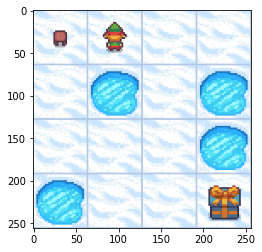

In [16]:
env = gym.make('FrozenLake-v1', desc=None,
               map_name="4x4",
               is_slippery=False)
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(20):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  time.sleep(0.5)
  if done:
    env.reset()
env.close()

In [4]:
env.observation_space.n

16

In [5]:
env.action_space.n

4

In [6]:
action_size = env.action_space.n
state_size = env.observation_space.n
# rows-->states columns-->actions
q_table = np.zeros([state_size,action_size])

In [7]:
q_table.shape

(16, 4)

In [8]:
EPOCHS=20000 # episodes
ALPHA=0.8 # learning rate
GAMMA=0.95 # discount rate

In [9]:
epsilon=1.0 # exploration rate
max_epsilon=1.0
min_epsilon=0.01
decay_rate=0.001

In [10]:
# Epsilon greedy action selection function
def epsilon_greedy_action_selection(epsilon,q_table,discrete_state):
  random_number = np.random.random()
  # EXPLOITATION: choose action that maximizes Q
  if random_number > epsilon:
    state_row = q_table[discrete_state,:]
    action = np.argmax(state_row)
  # EXPLORATION: choose a random action
  else:
    action = env.action_space.sample()
  return action

In [11]:
def compute_next_q_value(old_q_value,reward,next_optimal_q_value):
  return old_q_value + ALPHA * (reward + GAMMA*next_optimal_q_value - old_q_value)

In [12]:
def reduce_epsilon(epsilon,epoch):
  return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

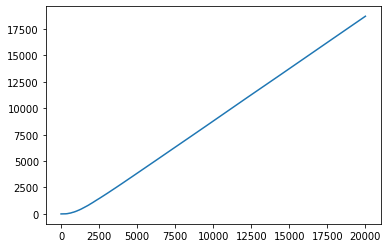

In [13]:
rewards = []
log_interval = 1000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
epoch_plot_tracker = []
total_reward_plot_tracker = []

for episode in range(EPOCHS):
  state = env.reset()
  done = False
  total_rewards = 0
  # Agent plays game
  while not done:
    # ACTION
    action = epsilon_greedy_action_selection(epsilon,q_table,state)
    # state, reward... env.step()
    new_state, reward, done, info = env.step(action)
    # OLD (Current) Q VALUE
    old_q_value = q_table[state,action]
    # Get next optimal Q Value
    next_optimal_q_value = np.max(q_table[new_state,:])
    # Compute next Q Value
    next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
    # Update the table
    q_table[state,action] = next_q
    # track reward
    total_rewards = total_rewards + reward
    # new state is now the state
    state = new_state
  
  # Agent finished a round of the game
  episode += 1
  epsilon = reduce_epsilon(epsilon,episode)
  rewards.append(total_rewards)
  total_reward_plot_tracker.append(np.sum(rewards))
  epoch_plot_tracker.append(episode)
  
  if episode % log_interval == 0:
    # print(np.sum(rewards))
    ax.clear()
    ax.plot(epoch_plot_tracker, total_reward_plot_tracker)
    fig.canvas.draw()

env.close()

In [14]:
q_table

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77151448, 0.72225251],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

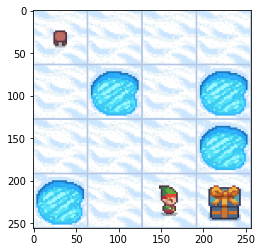

In [15]:
state = env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(100):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = np.argmax(q_table[state,:])
  state,reward,done,info = env.step(action)
  time.sleep(1)
  if done:
    break
env.close()